## Load libraries

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# %reset out

In [ ]:
import os,sys
import re
import math
from datetime import datetime
import time
sys.dont_write_bytecode = True

In [ ]:
import pandas as pd
import joblib

import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt

from skimage.color import rgb2gray
from skimage.transform import resize

from pprint import pprint
from pathlib import Path
from typing import List, Set, Dict, Tuple, Optional, Iterable, Mapping, Union
from ipdb import set_trace

In [ ]:
# import holoviews as hv
# from holoviews import opts
# hv.extension('bokeh')

In [ ]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data.dataset import Dataset
from torchvision import datasets, transforms
from torch.autograd import Variable

import pyro
from pyro.distributions import MultivariateNormal, Normal

Dist = torch.distributions.Distribution
# Dist = Union[torch.distributions.Distribution, pyro.distributions.Distribution]

## Set Path


In [ ]:
this_nb_path = Path(os.getcwd())
ROOT = this_nb_path.parent
SRC = ROOT/'src'
paths2add = [this_nb_path, ROOT]

print("Project root: ", str(ROOT))
print('Src folder: ', str(SRC))
print("This nb path: ", str(this_nb_path))


for p in paths2add:
    if str(p) not in sys.path:
        sys.path.insert(0, str(p))
        print(str(p), "added to the path\n")
        
print(sys.path)

In [ ]:
# Import libraries from the source
from src.models.GMM import GMM


## Helpers

In [ ]:
def now2str():
    now = datetime.now()
    now_str = now.strftime("%m_%d_%H:%M:%S")
    return now_str

def info(arr, header=None):
    if header is None:
        header = "="*30
    print(header)
    print("shape: ", arr.shape)
    print("dtype: ", arr.dtype)
    print("min, max: ", min(np.ravel(arr)), max(np.ravel(arr)))
    
def make_guassian(mean: torch.Tensor, cov: torch.Tensor) -> Dist:
    return MultivariateNormal(mean, cov)

def make_gaussians(means: torch.Tensor, covs: torch.Tensor) -> Iterable[Dist]:
    ds = []
    K = means.shape[-1]
    for k in range(K):
        ds.append(MultivariateNormal(means[k], covs[k]))
    return ds

In [ ]:
#  src: https://scipython.com/book/chapter-7-matplotlib/examples/bmi-data-with-confidence-ellipses/
from matplotlib.patches import Ellipse

def get_cov_ellipse(mean, cov, n_std, **kwargs):
    """
    Return a matplotlib Ellipse patch representing the covariance matrix
    cov centred at centre and scaled by the factor n_std.

    Usage:
    e = get_cov_ellipse(cov, (height_mean, mass_mean), 3,
                        fc=colours[gender], alpha=0.4)
    ax.add_artist(e)
    """
    if  isinstance(mean, np.ndarray) and mean.ndim == 2:
        mean = mean.flatten()
        
    # Find and sort eigenvalues and eigenvectors into descending order
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # The anti-clockwise angle to rotate our ellipse by 
    vx, vy = eigvecs[:,0][0], eigvecs[:,0][1]
    theta = np.arctan2(vy, vx)

    # Width and height of ellipse to draw
    width, height = 2 * n_std * np.sqrt(eigvals)
    return Ellipse(xy=mean, width=width, height=height,
                   angle=np.degrees(theta), **kwargs)

## Implementation
- Ref: PRML Sec 9.2

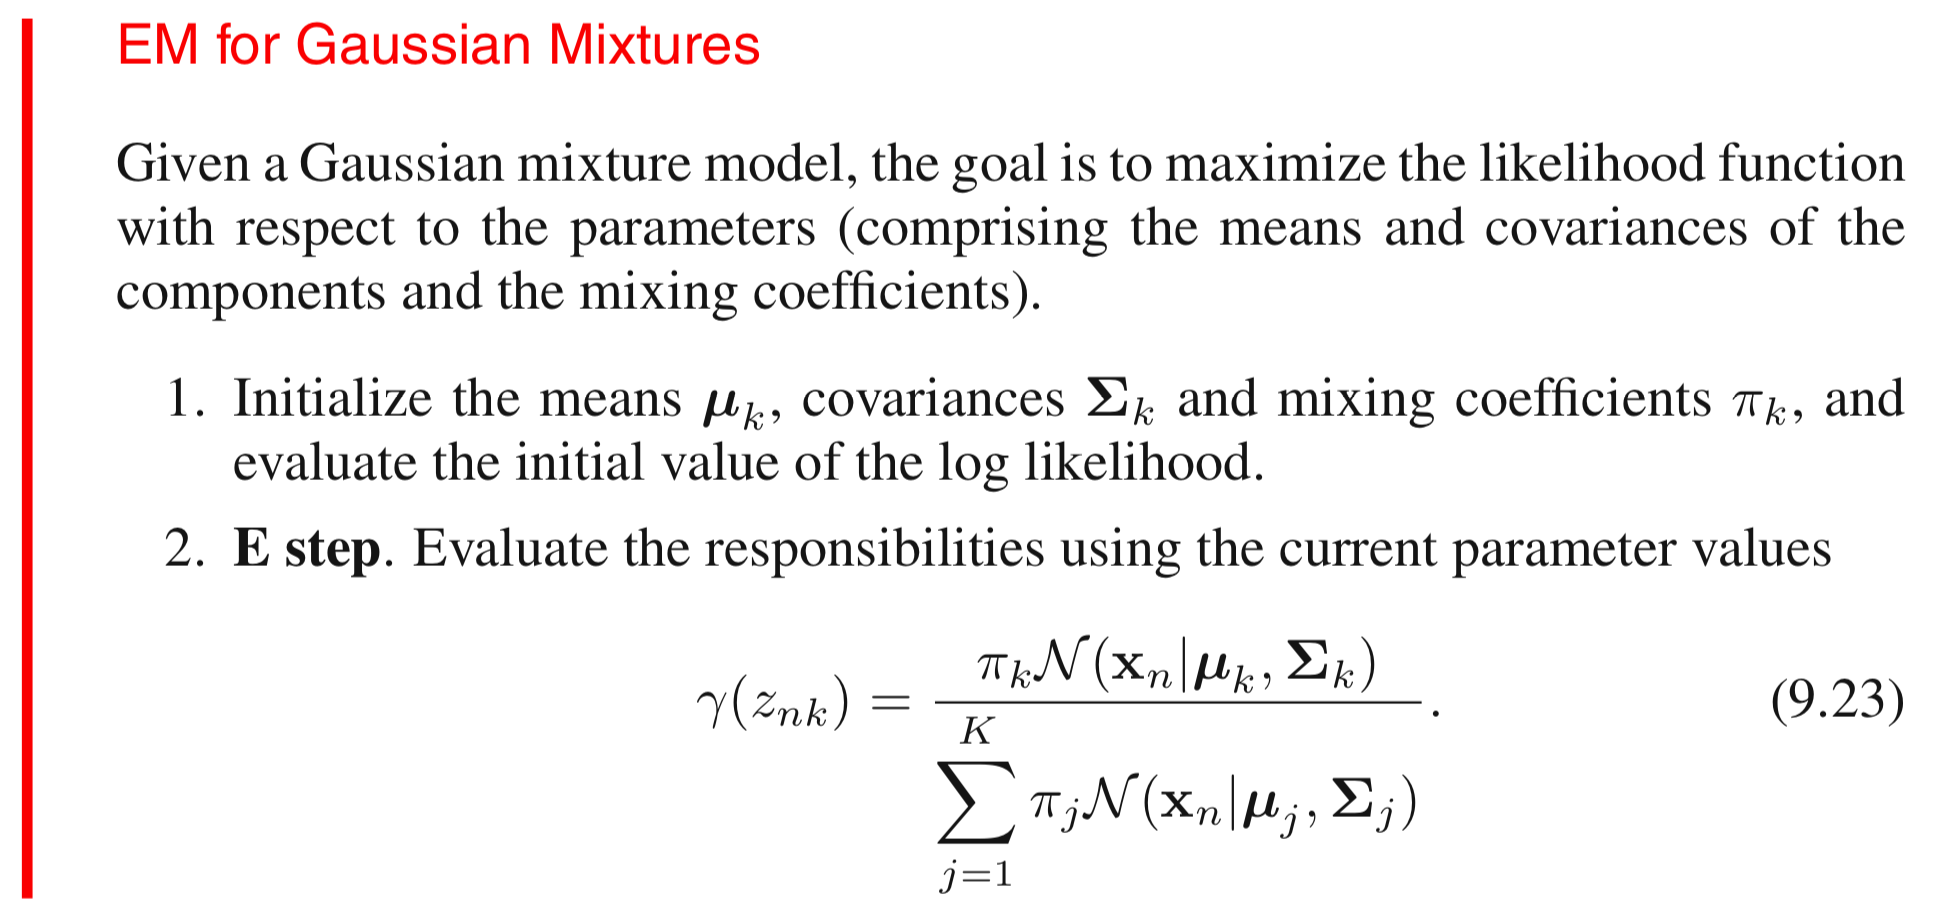
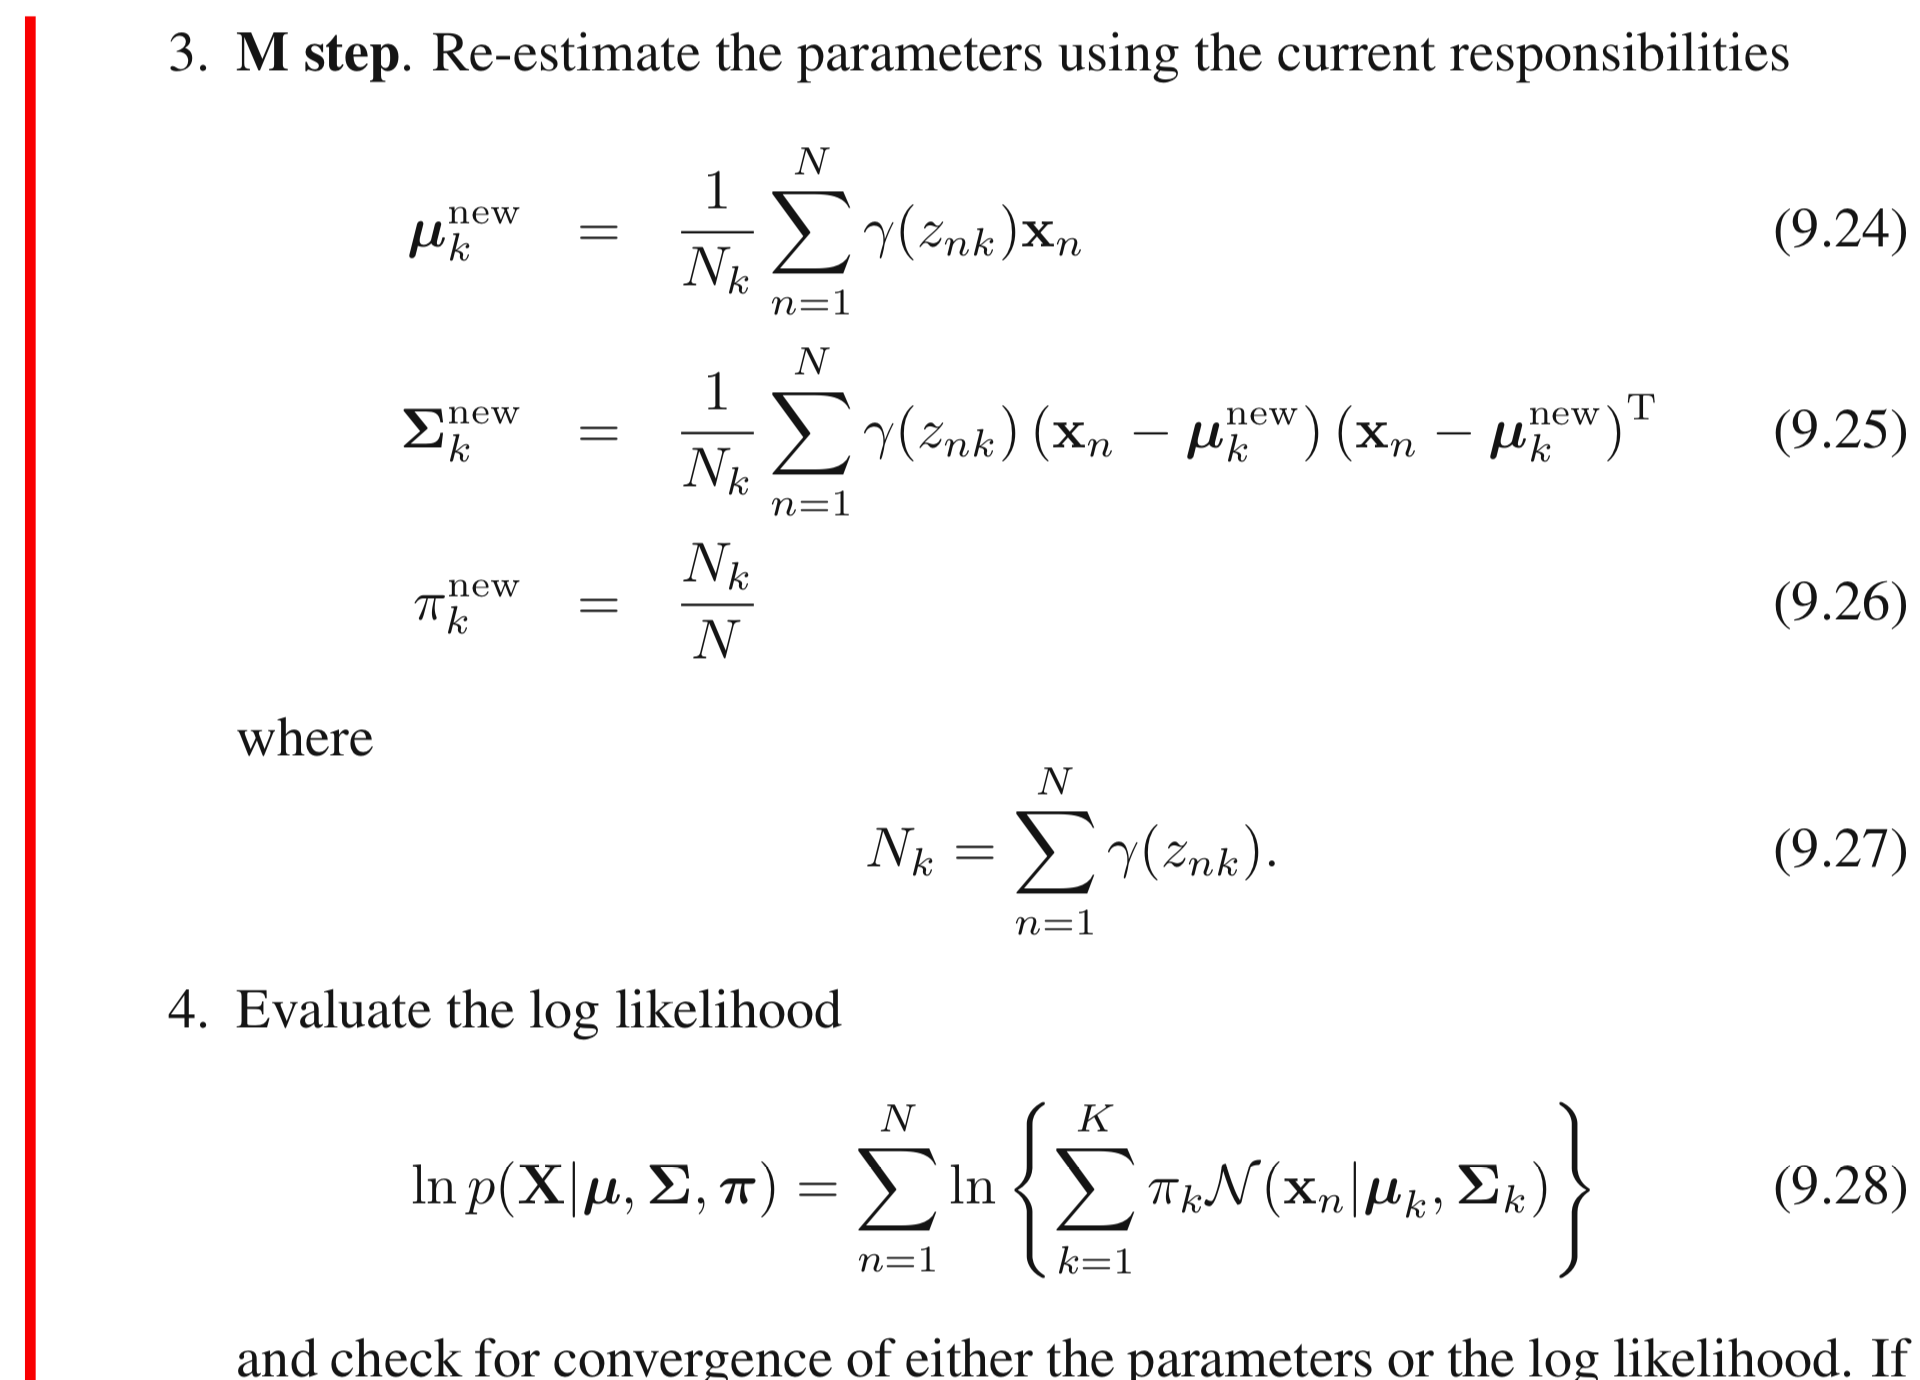


In [ ]:
class GMM():
    """Mixture of Gaussians (MoG), aka. Gaussian Mixture Model (GMM) Implementation.
    Caveat: this implementation does not handle the model collapsing of GMM.
    
    Model parameters:
    - pi (vector of length K): [pi_1, ... pi_K]
    - means (matrix of shape (K, dim_x): Each kth row is a vector of length dim_x that represents a center of
     the kth Gaussian component distribution
    - covs (3dim tensor of shape (K, dim_x, dim_x): Each kth matrix is a covariance matrix for the kth gaussian component
    distribution



    Learning algorithm: EM method applied to Guassian Mixture Model. See PRML Ch 9.2
    - Estep: choose the posterior probability function of Z|X; \theta to be
    the one that lower-bounds the ELBO objective function tightest, given the observed
    data X and current iteration's model parameter values.

    - Mstep: Compute the new values for the model parameters s.t. the new values maximizes
    the ELBO, given the observed data and the posterior probabilities (ie. the soft mixture assignment
    for each data point)


    """
    def __init__(self, obs: Union[torch.Tensor, np.ndarray], n_mixtures: int, dtype=None, 
                device='cpu'):
        self.K = n_mixtures
        self.N, self.D = obs.shape
        self.dtype = torch.float32 if dtype is None else dtype
        self.obs = obs
        self.device=device
        
        # Initialize the model parameters as random initial values
        self.pi = torch.ones(self.K, dtype=self.dtype).div(self.K) # Uniform prior on mixing coefficients
        self.means = torch.randn(self.K, self.D, dtype=self.dtype)
        self.covs = torch.zeros(self.K, self.D, self.D, dtype=self.dtype)
        for k in range(self.K):
            self.covs[k] = torch.diagflat(torch.ones(self.D, dtype=self.dtype)) # initialize with identity mtx
        
        
        # Register model parameters as in a dictionary 
        # todo: as a global dictionary. Note - this is why pyro maintains a similar global dict
#         self.params = {'pi': self.pi,
#                        'means': self.means,
#                        'covs': self.covs}

        # Initialize posterior probabilities for each data point: R
        self.R = torch.zeros(self.N, self.K, dtype=self.dtype)
        self.update_posterior()

    @property    
    def params(self):
        return {'pi': self.pi,
               'means': self.means,
               'covs': self.covs}
    
    @property
    def gaussians(self):
        return make_gaussians(self.means, self.covs)

        
    def log_prob(self, X: Union[torch.Tensor, np.ndarray]=None, reduction: str='sum') -> float:
        """
        Compute the loglikelihood of the observation data X.
        
        Args:
        - X: Observed data
            - If it's not given, evaluate the loglikelihood of the observation data 
            at initialization of this object
        - reduction (str): similar to torch.nn.MSELoss's `reduction` keyword.
            - 'mean': the llh is averaged over each llh element in the batch, 
            ie. we divide the sum of loglikelihood at all observation points by number of observations

            - 'sum': the returned llh is sumed over each llh element in the batch
        """
        llh = torch.zeros_like(X)
        if X is None:
            X = self.obs
        for k,dist in enumerate(self.gaussians):
            llh += self.pi[k] * dist.log_prob(X)
        
        if reduction == 'mean':
            return llh.mean().item()
        elif reduction == 'sum':
            return llh.sum().item()
        else:
            raise ValueError(f"reduction must be either mean or sum: {reduction}")
        
        
    def update_posterior(self):
        """Estep: Evaluate the posterior probabilities (p(z_n|X,\theta)) given the observed data
        and the current values of the model parameters"""
        # Zero out R
        self.R = torch.zeros(self.N, self.K, dtype=self.dtype)
        normalizer = torch.zeros(self.N, 1, dtype=self.dtype)
        
        for k,dist in enumerate(self.gaussians):
            self.R[:,k] = self.pi[k] * dist.log_prob(self.obs)
            normalizer += self.R[:,[k]]
        self.R.div_(normalizer)
        
        
        
    def update_params(self):
        """Mstep: Re-estimate the model parameters using the current posterior probabilities (and 
        observed data)"""
        counts = self.R.sum(dim=0)
        assert counts.shape[-1] == self.K
        
        # re-estimate means and covariances
        for k in range(K):
            # Mean
            self.means[k] = (self.R[:,[k]]*self.obs).sum(dim=0).div(counts[k])
#             print(k, self.means[k].shape)
            
            # Covariance
            centered = self.obs - self.means[[k]]
            cov = torch.zeros(self.D, self.D, dtype=self.dtype, device=self.device)
            assert cov.shape == (self.D, self.D)
            for n in range(len(self.obs)):
                centered = self.obs[[n]] - self.means[[k]]
                cov += self.R[n,k] * torch.matmul(centered.T, centered)
            self.covs[k] = cov.div(counts[k])
        
        # Re-estimate mixture proportions
        self.pi = counts.div(self.N)
        
    def step(self):
        self.update_posterior()
        self.update_params()
        
    
    def info(self):
        for name, param in self.params.items():
            print(f"==={name}===")
            print(param.numpy())
        print(f"===posterior probs===")
        print(self.R)
    
    def visualize_model(self, title: str='GMM', padx: float=5., pady: float=5., cmap: str='Set1'):
        """Note:Works for 2dim gaussians only.
        Visualize the component gaussian (conditional) distributions as ellipse (w/ each dist's center 
        and 1 std)
        
        For matplotlib.cm, refer to this example:
        - https://matplotlib.org/tutorials/colors/colormaps.html#codecell8:~:text=%23%20Indices%20to%20step%20through%20colormap,-x
        """
        if self.D != 2:
            print("Only 2Dim gaussians are supported.")
            return 
        xmin, ymin = self.means.min(dim=0).values
        xmax, ymax = self.means.max(dim=0).values
        xlim = (xmin.item() - padx, xmax.item() + padx)
        ylim = (ymin.item() - pady, ymax.item() + pady)
        
        f, ax = plt.subplots()
        f.suptitle(title)
        # Indices to step through colormap
        cmap_inds = np.linspace(0.0, 1.0, self.K)
        colors = cm.get_cmap(plt.get_cmap(cmap))(cmap_inds)[:, :3]
        for k in range(self.K):
#             print(k, colors[k])
            ax.scatter(self.means[k,0],self.means[k,1], label=f'{k}', s=10, c=colors[[k]])
            e = get_cov_ellipse(self.means[k], self.covs[k], n_std=1, fc=colors[k], alpha=0.3)
            ax.add_artist(e)
        ax.set_aspect('equal')
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.legend()
                    
        return f
    
    
    def visualize_assignments(self, title: str='Assignments', cmap: str='Set1'):
        # Indices to step through colormap
        cmap_inds = np.linspace(0.0, 1.0, self.K)
        colors = cm.get_cmap(plt.get_cmap(cmap))(cmap_inds)[:, :3]
        
        f,ax = plt.subplots()
        f.suptitle(title)
        for n in range(self.N):
            x = self.obs[n]
            # posterior probs {r_k}
            ratios = self.R[n]
            assert torch.isclose(ratios.sum(), torch.tensor(1.0))

            for k, ratio in enumerate(ratios):
                ax.scatter(*x, s=10, c=colors[[k]], alpha=ratio.item())
        return f
                
        
    def visualize(self, title: str="GMM", cmap: str='Set1', fig_kw: Optional[Dict]=None):
        """Note:Works for 2dim gaussians only.
        Visualizes current GMM model and posterior probs (aka. soft assignments of all data)
        """
        if self.D != 2:
            print("Only 2Dim gaussians are supported.")
            return 
        
        f, ax = plt.subplots() if fig_kw is None else plt.subplots(**fig_kw)
        f.suptitle(title)
        # Indices to step through colormap
        cmap_inds = np.linspace(0.0, 1.0, self.K)
        colors = cm.get_cmap(plt.get_cmap(cmap))(cmap_inds)[:, :3]
        
        # Draw gaussian dists as ellipses
        for k in range(self.K):
            ax.scatter(self.means[k,0],self.means[k,1], label=f'{k}', s=10, c=colors[[k]])
            e = get_cov_ellipse(self.means[k], self.covs[k], n_std=1, fc=colors[k], alpha=0.3)
            ax.add_artist(e)
            
        # Show each data point's soft assignmenets
        for n in range(self.N):
            x = self.obs[n]
            # posterior probs {r_k}
            ratios = self.R[n]
            assert torch.isclose(ratios.sum(), torch.tensor(1.0))

            for k, ratio in enumerate(ratios):
                ax.scatter(*x, s=10, c=colors[[k]], alpha=ratio.item())
            
            
            
        ax.set_aspect('equal', 'datalim')
        ax.legend()
        return f



todo: set heuristic to prevent mode collapsing


In [ ]:
class GMM_V2():
    """Mixture of Gaussians (MoG), aka. Gaussian Mixture Model (GMM) Implementation.
    This implementation handles the mode collapsing that can happen while learning *multiple* gaussian 
    components under the maximum-likelihood criterion. 
    Here we use the heuristic to set the mean to a random number and cov to be some large det. when a component's 
    mean becomes  exactly the same as one of the data points. 
    Althernatively, one can train the GMM under the maximum-a-posteioriory criterion to avoid the mode collaping
    
    
    Model parameters:
    - pi (vector of length K): [pi_1, ... pi_K]
    - means (matrix of shape (K, dim_x): Each kth row is a vector of length dim_x that represents a center of
     the kth Gaussian component distribution
    - covs (3dim tensor of shape (K, dim_x, dim_x): Each kth matrix is a covariance matrix for the kth gaussian component
    distribution



    Learning algorithm: EM method applied to Guassian Mixture Model. See PRML Ch 9.2
    - Estep: choose the posterior probability function of Z|X; \theta to be
    the one that lower-bounds the ELBO objective function tightest, given the observed
    data X and current iteration's model parameter values.

    - Mstep: Compute the new values for the model parameters s.t. the new values maximizes
    the ELBO, given the observed data and the posterior probabilities (ie. the soft mixture assignment
    for each data point)


    """
    def __init__(self, obs: Union[torch.Tensor, np.ndarray], n_mixtures: int, dtype=None, 
                device='cpu'):
        self.K = n_mixtures
        self.N, self.D = obs.shape
        self.dtype = torch.float32 if dtype is None else dtype
        self.obs = obs
        self.device=device
        
        # Initialize the model parameters as random initial values
        self.pi = torch.ones(self.K, dtype=self.dtype).div(self.K) # Uniform prior on mixing coefficients
        self.means = torch.randn(self.K, self.D, dtype=self.dtype)
        self.covs = torch.zeros(self.K, self.D, self.D, dtype=self.dtype)
        for k in range(self.K):
            self.covs[k] = torch.diagflat(torch.ones(self.D, dtype=self.dtype)) # initialize with identity mtx
        
        
        # Register model parameters as in a dictionary 
        # todo: as a global dictionary. Note - this is why pyro maintains a similar global dict
#         self.params = {'pi': self.pi,
#                        'means': self.means,
#                        'covs': self.covs}

        # Initialize posterior probabilities for each data point: R
        self.R = torch.zeros(self.N, self.K, dtype=self.dtype)
        self.update_posterior()

    @property    
    def params(self):
        return {'pi': self.pi,
               'means': self.means,
               'covs': self.covs}
    
    @property
    def gaussians(self):
        return make_gaussians(self.means, self.covs)

        
    def log_prob(self, X: Union[torch.Tensor, np.ndarray]=None, reduction: str='sum') -> float:
        """
        Compute the loglikelihood of the observation data X.
        
        Args:
        - X: Observed data
            - If it's not given, evaluate the loglikelihood of the observation data 
            at initialization of this object
        - reduction (str): similar to torch.nn.MSELoss's `reduction` keyword.
            - 'mean': the llh is averaged over each llh element in the batch, 
            ie. we divide the sum of loglikelihood at all observation points by number of observations

            - 'sum': the returned llh is sumed over each llh element in the batch
        """
        llh = torch.zeros_like(X)
        if X is None:
            X = self.obs
        for k,dist in enumerate(self.gaussians):
            llh += self.pi[k] * dist.log_prob(X)
        
        if reduction == 'mean':
            return llh.mean().item()
        elif reduction == 'sum':
            return llh.sum().item()
        else:
            raise ValueError(f"reduction must be either mean or sum: {reduction}")
        
        
    def update_posterior(self):
        """Estep: Evaluate the posterior probabilities (p(z_n|X,\theta)) given the observed data
        and the current values of the model parameters"""
        # Zero out R
        self.R = torch.zeros(self.N, self.K, dtype=self.dtype)
        normalizer = torch.zeros(self.N, 1, dtype=self.dtype)
        
        for k,dist in enumerate(self.gaussians):
            self.R[:,k] = self.pi[k] * dist.log_prob(self.obs)
            normalizer += self.R[:,[k]]
        self.R.div_(normalizer)
        
        
        
    def update_params(self):
        """Mstep: Re-estimate the model parameters using the current posterior probabilities (and 
        observed data)"""
        counts = self.R.sum(dim=0)
        assert counts.shape[-1] == self.K
        
        # re-estimate means and covariances
        for k in range(K):
            # Mean
            self.means[k] = (self.R[:,[k]]*self.obs).sum(dim=0).div(counts[k])
#             print(k, self.means[k].shape)
            
            # Covariance
            centered = self.obs - self.means[[k]]
            cov = torch.zeros(self.D, self.D, dtype=self.dtype, device=self.device)
            assert cov.shape == (self.D, self.D)
            for n in range(len(self.obs)):
                centered = self.obs[[n]] - self.means[[k]]
                cov += self.R[n,k] * torch.matmul(centered.T, centered)
            self.covs[k] = cov.div(counts[k])
        
        # Re-estimate mixture proportions
        self.pi = counts.div(self.N)
        
    def step(self):
        self.update_posterior()
        self.update_params()
        
    
    def info(self):
        for name, param in self.params.items():
            print(f"==={name}===")
            print(param.numpy())
        print(f"===posterior probs===")
        print(self.R)
    
    def visualize_model(self, title: str='GMM', padx: float=5., pady: float=5., cmap: str='Set1'):
        """Note:Works for 2dim gaussians only.
        Visualize the component gaussian (conditional) distributions as ellipse (w/ each dist's center 
        and 1 std)
        
        For matplotlib.cm, refer to this example:
        - https://matplotlib.org/tutorials/colors/colormaps.html#codecell8:~:text=%23%20Indices%20to%20step%20through%20colormap,-x
        """
        if self.D != 2:
            print("Only 2Dim gaussians are supported.")
            return 
        xmin, ymin = self.means.min(dim=0).values
        xmax, ymax = self.means.max(dim=0).values
        xlim = (xmin.item() - padx, xmax.item() + padx)
        ylim = (ymin.item() - pady, ymax.item() + pady)
        
        f, ax = plt.subplots()
        f.suptitle(title)
        # Indices to step through colormap
        cmap_inds = np.linspace(0.0, 1.0, self.K)
        colors = cm.get_cmap(plt.get_cmap(cmap))(cmap_inds)[:, :3]
        for k in range(self.K):
#             print(k, colors[k])
            ax.scatter(self.means[k,0],self.means[k,1], label=f'{k}', s=10, c=colors[[k]])
            e = get_cov_ellipse(self.means[k], self.covs[k], n_std=1, fc=colors[k], alpha=0.3)
            ax.add_artist(e)
        ax.set_aspect('equal')
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.legend()
                    
        return f
    
    
    def visualize_assignments(self, title: str='Assignments', cmap: str='Set1'):
        # Indices to step through colormap
        cmap_inds = np.linspace(0.0, 1.0, self.K)
        colors = cm.get_cmap(plt.get_cmap(cmap))(cmap_inds)[:, :3]
        
        f,ax = plt.subplots()
        f.suptitle(title)
        for n in range(self.N):
            x = self.obs[n]
            # posterior probs {r_k}
            ratios = self.R[n]
            assert torch.isclose(ratios.sum(), torch.tensor(1.0))

            for k, ratio in enumerate(ratios):
                ax.scatter(*x, s=10, c=colors[[k]], alpha=ratio.item())
        return f
                
        
    def visualize(self, title: str="GMM", cmap: str='Set1', fig_kw: Optional[Dict]=None):
        """Note:Works for 2dim gaussians only.
        Visualizes current GMM model and posterior probs (aka. soft assignments of all data)
        """
        if self.D != 2:
            print("Only 2Dim gaussians are supported.")
            return 
        
        f, ax = plt.subplots() if fig_kw is None else plt.subplots(**fig_kw)
        f.suptitle(title)
        # Indices to step through colormap
        cmap_inds = np.linspace(0.0, 1.0, self.K)
        colors = cm.get_cmap(plt.get_cmap(cmap))(cmap_inds)[:, :3]
        
        # Draw gaussian dists as ellipses
        for k in range(self.K):
            ax.scatter(self.means[k,0],self.means[k,1], label=f'{k}', s=10, c=colors[[k]])
            e = get_cov_ellipse(self.means[k], self.covs[k], n_std=1, fc=colors[k], alpha=0.3)
            ax.add_artist(e)
            
        # Show each data point's soft assignmenets
        for n in range(self.N):
            x = self.obs[n]
            # posterior probs {r_k}
            ratios = self.R[n]
            assert torch.isclose(ratios.sum(), torch.tensor(1.0))

            for k, ratio in enumerate(ratios):
                ax.scatter(*x, s=10, c=colors[[k]], alpha=ratio.item())
            
            
            
        ax.set_aspect('equal', 'datalim')
        ax.legend()
        return f



## Dataset
Ref: [sklearn: Density Estimation for a Gaussian mixture](https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#sphx-glr-auto-examples-mixture-plot-gmm-pdf-py)

To create 2dim samples from a gaussian distrituion, use:

    `np.random.multivariate_normal(mean, cov, n_samples)` --> np.array of sizse (n_sample, 2)

Let's first create a controlled dataset whose underlying distributions' parameters are chosen by us:

Ground truth: two underlying population (ie. K=2)
- Component gaussian distribution 1: mu_1 = [1., 1.], Sigma_1 = [[1,0], [0.,2]]
- Component gaussian distribution 2: mu_2 = [-2., 2.], Sigma_2 = [[1,0.5],[0.5, 1.]]
- pi = [pi_1, pi_2]: ratio of each component = [0.2, 0.8]
- N: number of data points
- K: number of clusters 
- D: dimensionality of a data variable

In [ ]:
N = 200
pi = [0.2, 0.8]
N0 = int(N*pi[0])
N1 = N-N0

K = 2
D = 2

# todo: 
# - [ ] make the tensor objects of the model parameters with kwarg "requires_grad=True"
# - [ ] set device to a designated gpu
device = 'cpu'
dtype = torch.float32
req_grad = False
pin_memory = True

# First gaussian component distribution
mu0 = torch.tensor([2., 2.], requires_grad=req_grad, pin_memory=pin_memory, dtype=dtype, device=device)
sigma0 = torch.tensor([[1,0], [0,1.]], requires_grad=req_grad, pin_memory=pin_memory, dtype=dtype, device=device)
d0 = MultivariateNormal(mu0, sigma0)
sample0 = d0.sample((N0,))

# Second component distribution
mu1 = torch.tensor([-3., -2], requires_grad=req_grad, pin_memory=pin_memory, dtype=dtype, device=device)
sigma1 = torch.tensor([[1,0.5],[0.5, 1]], requires_grad=req_grad, pin_memory=pin_memory, dtype=dtype, device=device)
d1 = MultivariateNormal(mu1, sigma1)
sample1 = d1.sample((N1,))

X = torch.vstack([sample0, sample1])
labels = np.r_[[0]*N0, [1]*N1]
Y = torch.tensor(labels).reshape((len(X),-1))
data = torch.hstack([X,Y])
print(data.shape)

In [ ]:
df_data = pd.DataFrame(data,columns='x0_x1_label'.split('_'))
df_data.head()


In [ ]:
df_data = df_data.applymap(lambda t: t.item())
df_data.head()


In [ ]:
f, ax = plt.subplots(figsize=(10,10))
ax.scatter(X[:N0,0], X[:N0,1], c='r', s=5, label='0')
ax.scatter(*mu0, c='k', s=50, marker="*")

ax.scatter(X[N0:,0], X[N0:,1], c='b', s=5, label='1')
ax.scatter(*mu1, c='k', s=50, marker="*")

ax.legend()
ax.set_title('Ground-Truth labels')
ax.set_aspect('equal', 'datalim')

## Fit a GMM version 1 to this dataset
First, initial guess of the model parameters
This example will demonstrate the mode-collapsing in GMM w/ max-likelihood criterion.

In [ ]:
# Initial guess of the model parameters 
m_pi = [0.5, 0.5]

m_mu0 =  np.random.randn(2) # Use the result of KMeans
m_sigma0 =  np.array([[1.,0.],[0.,1.]])# unit, diag covariance

m_mu1 = np.random.randn(2)
m_sigma1 = np.array([[1.,0.],[0.,1.]])# unit, diag covariance


model_params = {'pi': m_pi,
               'mu0': m_mu0,
               'sigma0': m_sigma0,
               'mu1': m_mu1,
               'sigma1': m_sigma1}
visualize_model(model_params);

In [ ]:
plt.scatter([1],[0], c='r', alpha=0.2)

In [ ]:
plt.scatter(plt.scatter([1],[0], c='g', s=3, alpha=0.5)

In [ ]:
# Init test
td = X[np.r_[range(10), range(N-10,N)]]
td.shape

In [ ]:
m = GMM(td,2)
m.gaussians

In [ ]:
#Initial model w/o handling the singularity problem
# See PRML Sec 9.2
# m.visualize_model();
# m.visualize_assignments();
m.visualize();
# m.info()

In [ ]:
# one step
max_epoch = 10
for i in range(max_epoch):
    m.step()
    m.visualize()
    plt.show()
m.info()

##  Test the `src.models.GMM` class



In [ ]:
from src.models.GMM import GMM
K = 2
model = GMM(obs=X, n_mixtures=K)

In [ ]:
model.visualize_model(title="Initial");
model.visualize_assignments(title="Init. Assignments");

In [ ]:
# Fit the model to observed data
n_steps = 3
log_probs = []
show_every = 1#n_steps//3
for i in range(n_steps):
    model.step()
    log_probs.append(model.log_prob())

    if (i+1)%show_every == 0:
        model.visualize_model(title=f"Model: {i+1}")
        model.visualize_assignments(title=f"Assignments: {i+1}")
plt.plot(log_probs)
    

This shows the mode collapsing phenomenon of Mixture of Gaussians.
We can avoid this pitfall in the training procedure by either using a Maximum-a-posteriori as the optimization criteria, going one-level up bayesian, or implementing a heuristic to reassign the mean of a collapsed (to a data point) gaussian to a random point and its covariance matrix to be a diagonal matrix with large variances. 
